# Face Detection and Recognition

#### Using VGGFace and MTCNN

## By Brea Koenes

The `data` directory contains three folders 30 face images of three players from the 2024 Philadelphia Phillies: Alec Bohm, Bryson Stott, and Brandon Marsh. The original images were downloaded from Google Images and the face images were extraced using a `extract_faces` function. In addition, the `Samples` directory contains three images of a combination of those players.

Below, I create a system that can correctly detect and identify Bohm, Stott, and Marsh in those three sample images.

### Imports

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Imports
import subprocess
import sys
from IPython.display import clear_output
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN
import os
from tensorflow.keras.preprocessing import image
%matplotlib inline

In [2]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras)

2.19.0
<module 'tensorflow.keras' from 'C:\\Users\\USER\\anaconda3\\anaconda\\Lib\\site-packages\\keras\\_tf_keras\\keras\\__init__.py'>


In [3]:
from mtcnn import MTCNN
import cv2
import os
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Initialize MTCNN face detector
detector = MTCNN()

# Helper function to detect & crop faces
def detect_and_crop_face(img):
    faces = detector.detect_faces(img)
    if faces:
        # Get the first detected face
        x, y, width, height = faces[0]['box']
        x, y = abs(x), abs(y)  # Ensure non-negative
        cropped_face = img[y:y+height, x:x+width]
        cropped_face = cv2.resize(cropped_face, (224, 224))
        return cropped_face
    else:
        return None  # No face detected

# Load images from path with MTCNN cropping
def load_images_from_path(path, label):
    images, labels = [], []
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        if os.path.isfile(file_path):
            try:
                img = cv2.imread(file_path)
                if img is None:
                    print(f"Failed to load image: {file_path}")
                    continue
                
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                cropped_face = detect_and_crop_face(img_rgb)
                
                if cropped_face is not None:
                    images.append(cropped_face)
                    labels.append(label)
                else:
                    print(f"No face detected in: {file_path}")
                    
            except Exception as e:
                print(f"Skipping {file}: {e}")
    return images, labels

# Function to display images
def show_images(images):
    n = min(10, len(images))
    fig, axes = plt.subplots(1, n, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    if n == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
    plt.show()

x, y= [],[]

### Load and label images

In [4]:
celebrity = os.listdir('C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity')

In [5]:
celebrity

['ariana_grande',
 'emma_watson',
 'kyrie_irving',
 'michael_jordan',
 'stephen_curry',
 'taylor_swift']

In [6]:
for i in range(len(celebrity)):
    images, labels = load_images_from_path(f'C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\{celebrity[i]}',i)
    print(labels)
    x += images
    y += labels

Failed to load image: C:\Users\USER\Downloads\chinxuanhan\celebrity\ariana_grande\image_39.jpg
No face detected in: C:\Users\USER\Downloads\chinxuanhan\celebrity\ariana_grande\image_57.jpg
No face detected in: C:\Users\USER\Downloads\chinxuanhan\celebrity\ariana_grande\image_74.jpg
Failed to load image: C:\Users\USER\Downloads\chinxuanhan\celebrity\ariana_grande\image_9.jpg
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Failed to load image: C:\Users\USER\Downloads\chinxuanhan\celebrity\emma_watson\image_36.jpg
Failed to load image: C:\Users\USER\Downloads\chinxuanhan\celebrity\emma_watson\image_62.jpg
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [23]:
counts = [0] * 6

for label in y:
    counts[label] += 1

for idx, count in enumerate(counts):
    print(f"Class {idx}: {count} images")

Class 0: 76 images
Class 1: 78 images
Class 2: 69 images
Class 3: 65 images
Class 4: 74 images
Class 5: 71 images


### Prepare for VGGFace

In [24]:
# Preprocess pixels for VGGFace
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import preprocess_input

faces = preprocess_input(np.array(x))
labels = np.array(y)

# Split data into 50/50 into training/testing
# Trained w 5 random images of ea person, and validated w the same number of images
x_train, x_test, y_train, y_test = train_test_split(faces, labels, train_size=0.8, stratify=labels, random_state=42)

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(x_train, y_train, batch_size=16)
test_generator = test_datagen.flow(x_test, y_test, batch_size=16)

In [26]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(346, 224, 224, 3)
(87, 224, 224, 3)
(346,)
(87,)


### Create and train model

In [27]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Resizing, Flatten, Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_accuracy',     # or 'val_accuracy'
    patience=3,             # stop if no improvement for 3 epochs
    restore_best_weights=True
)
model = Sequential()
model.add(Resizing(224,224))
model.add(base_model)
model.add(Flatten())
model.add(Dense(64, activation='relu')) # changed from 8
model.add(Dense(6, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[early_stop],
    steps_per_epoch=len(train_generator),
    validation_steps=len(test_generator),
    verbose=1
)

Epoch 1/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.3582 - loss: 9.2345 - val_accuracy: 0.5747 - val_loss: 1.0167
Epoch 2/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.6105 - loss: 1.1108 - val_accuracy: 0.5632 - val_loss: 0.9502
Epoch 3/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7313 - loss: 0.8290 - val_accuracy: 0.7126 - val_loss: 0.8150
Epoch 4/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8069 - loss: 0.5754 - val_accuracy: 0.7701 - val_loss: 0.8494
Epoch 5/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8424 - loss: 0.5676 - val_accuracy: 0.8276 - val_loss: 0.5227
Epoch 6/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8632 - loss: 0.3661 - val_accuracy: 0.8046 - val_loss: 0.6384
Epoch 7/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.8795 - loss: 0.3950 - val_accuracy: 0.8506 - val_loss: 0.4886
Epoch 8/25
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9120 - loss: 0.2299 - val_accuracy: 0.7816 - val_loss:

[]

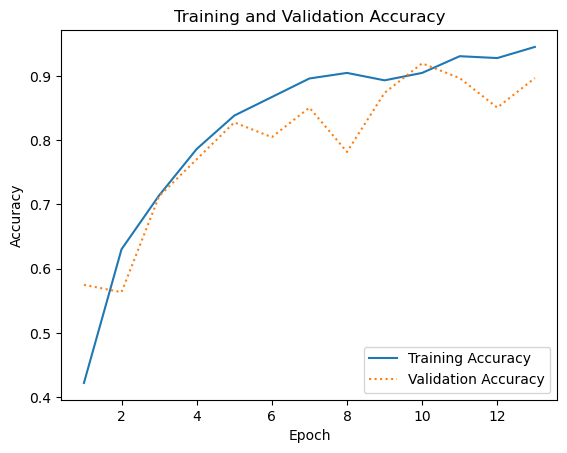

In [73]:
# Plot accuracy
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

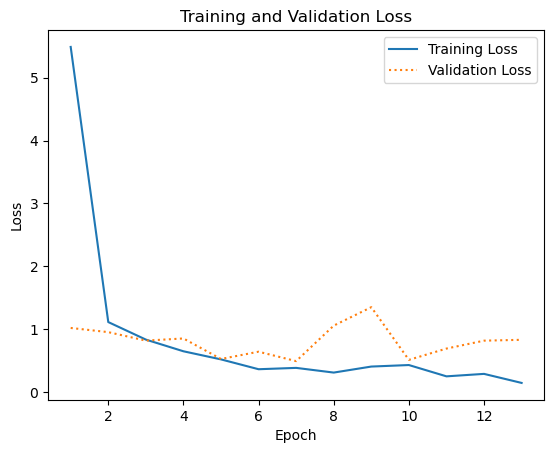

In [74]:
# Plot accuracy
acc = hist.history['loss']
val_acc = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

Number of test samples: 87
2/3 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepWARNING:tensorflow:5 out of the last 22 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000243200A3CE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step


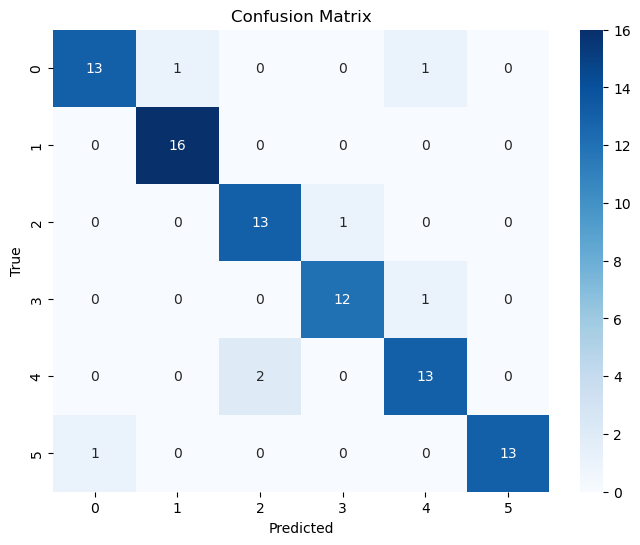

Confusion Matrix:
[[13  1  0  0  1  0]
 [ 0 16  0  0  0  0]
 [ 0  0 13  1  0  0]
 [ 0  0  0 12  1  0]
 [ 0  0  2  0 13  0]
 [ 1  0  0  0  0 13]]


In [38]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print(f"Number of test samples: {len(x_test)}")
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

cm = confusion_matrix(y_test, y_pred)

class_names = [0, 1, 2, 3, 4, 5]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Confusion Matrix:")
print(cm)

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

     Class 0       0.93      0.87      0.90        15
     Class 1       0.94      1.00      0.97        16
     Class 2       0.87      0.93      0.90        14
     Class 3       0.92      0.92      0.92        13
     Class 4       0.87      0.87      0.87        15
     Class 5       1.00      0.93      0.96        14

    accuracy                           0.92        87
   macro avg       0.92      0.92      0.92        87
weighted avg       0.92      0.92      0.92        87


=== PER-CLASS METRICS ===
Class 0: Precision=0.929, Recall=0.867, F1=0.897, Support=15
Class 1: Precision=0.941, Recall=1.000, F1=0.970, Support=16
Class 2: Precision=0.867, Recall=0.929, F1=0.897, Support=14
Class 3: Precision=0.923, Recall=0.923, F1=0.923, Support=13
Class 4: Precision=0.867, Recall=0.867, F1=0.867, Support=15
Class 5: Precision=1.000, Recall=0.929, F1=0.963, Support=1

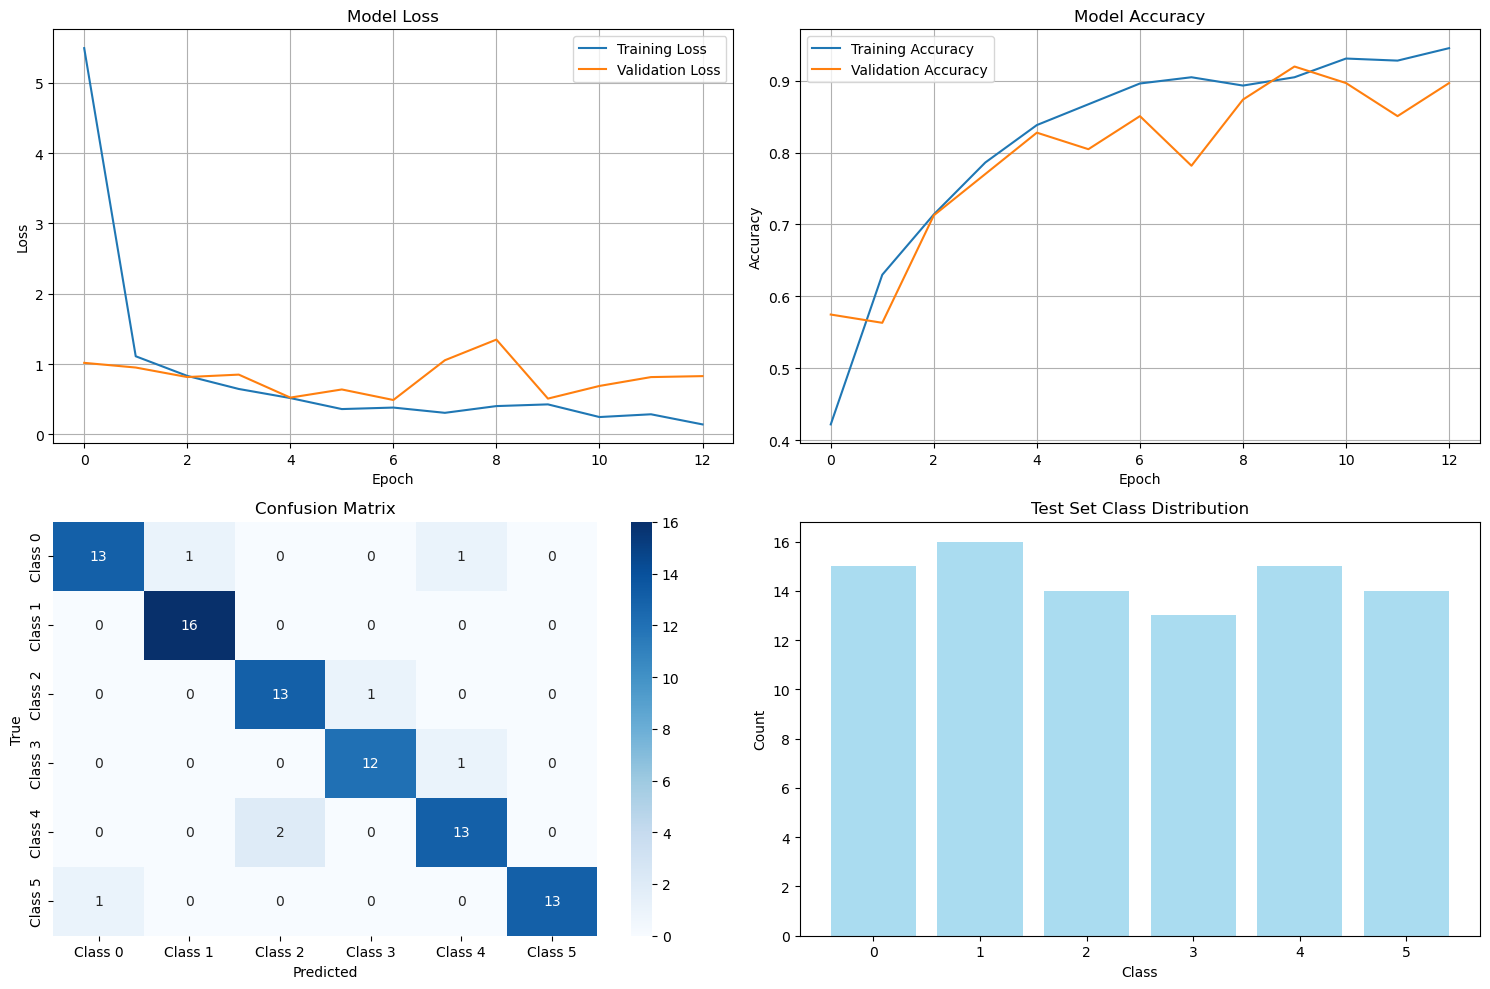

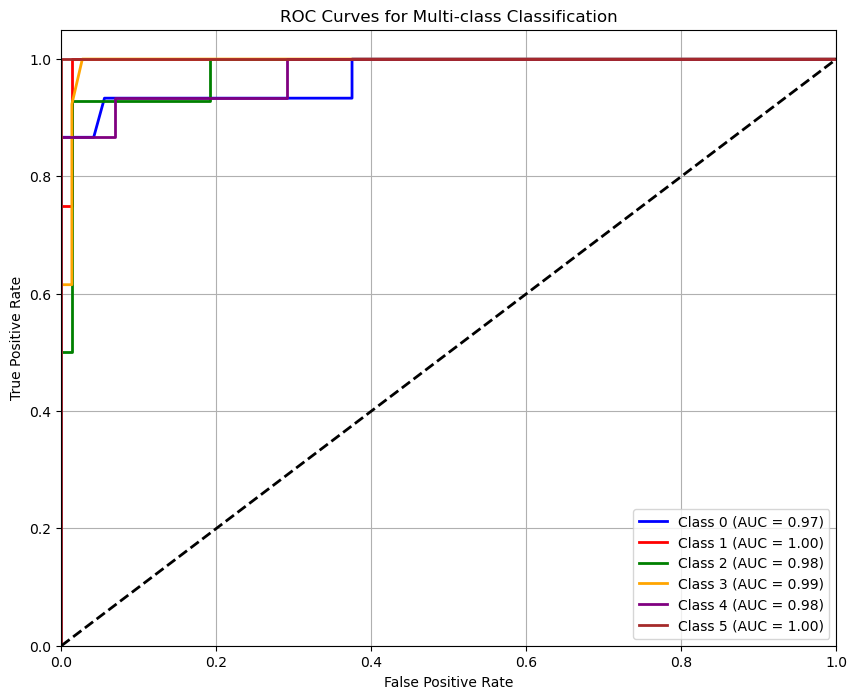


=== ROC AUC SCORES ===
Class 0 AUC: 0.972
Class 1 AUC: 0.996
Class 2 AUC: 0.980
Class 3 AUC: 0.994
Class 4 AUC: 0.976
Class 5 AUC: 1.000

=== TOP-K ACCURACY ===
Top-2 Accuracy: 0.943
Top-3 Accuracy: 0.977

=== PREDICTION CONFIDENCE ===
Average Confidence: 0.937
Min Confidence: 0.177
Max Confidence: 1.000


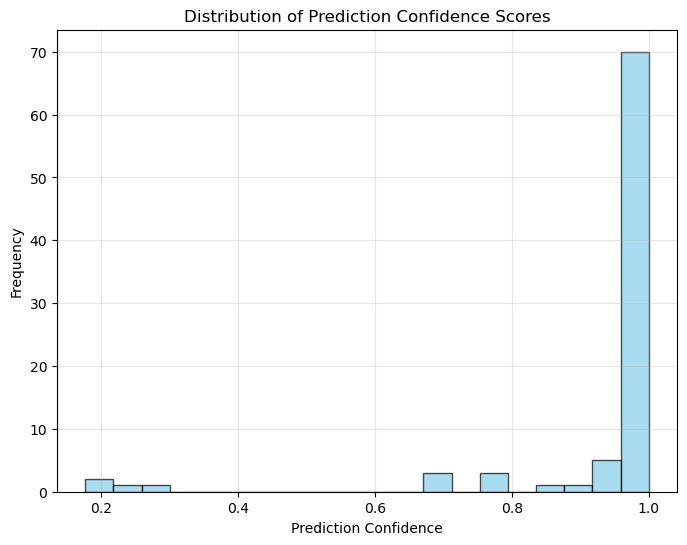


=== MISCLASSIFICATION ANALYSIS ===
Number of misclassified samples: 7
Misclassification rate: 0.080

First 10 misclassified examples:
Index 8: True=4, Predicted=2, Confidence=0.864
Index 10: True=3, Predicted=4, Confidence=0.177
Index 28: True=0, Predicted=4, Confidence=0.177
Index 37: True=2, Predicted=3, Confidence=1.000
Index 38: True=5, Predicted=0, Confidence=0.701
Index 69: True=4, Predicted=2, Confidence=1.000
Index 78: True=0, Predicted=1, Confidence=0.940


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_fscore_support,
    roc_curve, 
    auc,
    accuracy_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Get predictions
y_pred_prob = model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# 1. Classification Report (Precision, Recall, F1-Score)
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(6)]))

# 2. Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
print("\n=== PER-CLASS METRICS ===")
for i in range(6):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1={f1[i]:.3f}, Support={support[i]}")

# 3. Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\n=== OVERALL ACCURACY ===")
print(f"Accuracy: {accuracy:.3f}")

# 4. Training History Plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training/Validation Loss
axes[0,0].plot(hist.history['loss'], label='Training Loss')
axes[0,0].plot(hist.history['val_loss'], label='Validation Loss')
axes[0,0].set_title('Model Loss')
axes[0,0].set_xlabel('Epoch')
axes[0,0].set_ylabel('Loss')
axes[0,0].legend()
axes[0,0].grid(True)

# Training/Validation Accuracy
axes[0,1].plot(hist.history['accuracy'], label='Training Accuracy')
axes[0,1].plot(hist.history['val_accuracy'], label='Validation Accuracy')
axes[0,1].set_title('Model Accuracy')
axes[0,1].set_xlabel('Epoch')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend()
axes[0,1].grid(True)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
            xticklabels=[f'Class {i}' for i in range(6)],
            yticklabels=[f'Class {i}' for i in range(6)])
axes[1,0].set_xlabel('Predicted')
axes[1,0].set_ylabel('True')
axes[1,0].set_title('Confusion Matrix')

# Class Distribution
unique, counts = np.unique(y_test, return_counts=True)
axes[1,1].bar(unique, counts, color='skyblue', alpha=0.7)
axes[1,1].set_xlabel('Class')
axes[1,1].set_ylabel('Count')
axes[1,1].set_title('Test Set Class Distribution')
axes[1,1].set_xticks(range(6))

plt.tight_layout()
plt.show()

# 5. ROC Curves for Multi-class (One-vs-Rest)
if len(np.unique(y_test)) > 2:  # Multi-class
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=range(6))
    n_classes = y_test_bin.shape[1]
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Multi-class Classification')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    print("\n=== ROC AUC SCORES ===")
    for i in range(n_classes):
        print(f"Class {i} AUC: {roc_auc[i]:.3f}")

# 6. Top-K Accuracy (useful for multi-class)
def top_k_accuracy(y_true, y_pred_prob, k=2):
    top_k_pred = np.argsort(y_pred_prob, axis=1)[:, -k:]
    correct = 0
    for i, true_label in enumerate(y_true):
        if true_label in top_k_pred[i]:
            correct += 1
    return correct / len(y_true)

top_2_acc = top_k_accuracy(y_test, y_pred_prob, k=2)
top_3_acc = top_k_accuracy(y_test, y_pred_prob, k=3)

print(f"\n=== TOP-K ACCURACY ===")
print(f"Top-2 Accuracy: {top_2_acc:.3f}")
print(f"Top-3 Accuracy: {top_3_acc:.3f}")

# 7. Prediction Confidence Analysis
confidence_scores = np.max(y_pred_prob, axis=1)
print(f"\n=== PREDICTION CONFIDENCE ===")
print(f"Average Confidence: {np.mean(confidence_scores):.3f}")
print(f"Min Confidence: {np.min(confidence_scores):.3f}")
print(f"Max Confidence: {np.max(confidence_scores):.3f}")

# Plot confidence distribution
plt.figure(figsize=(8, 6))
plt.hist(confidence_scores, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence Scores')
plt.grid(True, alpha=0.3)
plt.show()

# 8. Misclassification Analysis
misclassified_indices = np.where(y_test != y_pred)[0]
print(f"\n=== MISCLASSIFICATION ANALYSIS ===")
print(f"Number of misclassified samples: {len(misclassified_indices)}")
print(f"Misclassification rate: {len(misclassified_indices)/len(y_test):.3f}")

# Show some misclassified examples (if you have access to the actual images)
if len(misclassified_indices) > 0:
    print("\nFirst 10 misclassified examples:")
    for i in misclassified_indices[:10]:
        print(f"Index {i}: True={y_test[i]}, Predicted={y_pred[i]}, Confidence={confidence_scores[i]:.3f}")

### Multi-Task Cascaded Convolutional Networks to detect faces

In [40]:
# Now that it's trained, focus on mtcnn

# Define 2 helper functions
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing import image
from matplotlib.patches import Rectangle

# Gets faces from specific location in the image
def get_face(image, face):
    x1, y1, w, h = face['box']
    
    if w > h:
        x1 = x1 + ((w - h) // 2)
        w = h
    elif h > w:
        y1 = y1 + ((h - w) // 2)
        h = w
        
    x2 = x1 + h
    y2 = y1 + w
    
    return image[y1:y2, x1:x2]

# Load photo and annotate face in photo w/ name and conf level
def label_faces(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    fig, ax = plt.subplots(figsize=size, subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(np_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        # Optionally draw a box around the face
        if show_outline:
            rect = Rectangle((x, y), w, h, color='red', fill=False, lw=2)
            ax.add_patch(rect)

        # Label the face
        index = int(np.argmax(predictions))
        text = f'{names[index]} ({confidence:.1%})'
        ax.text(x + (w / 2), y, text, color='white', backgroundcolor='red', ha='center', va='bottom', fontweight='bold', bbox=dict(color='red'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


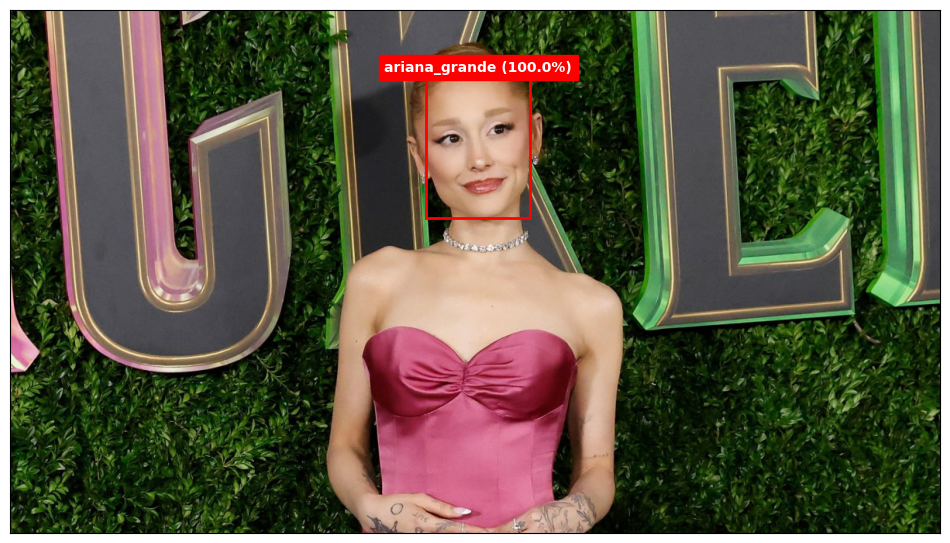

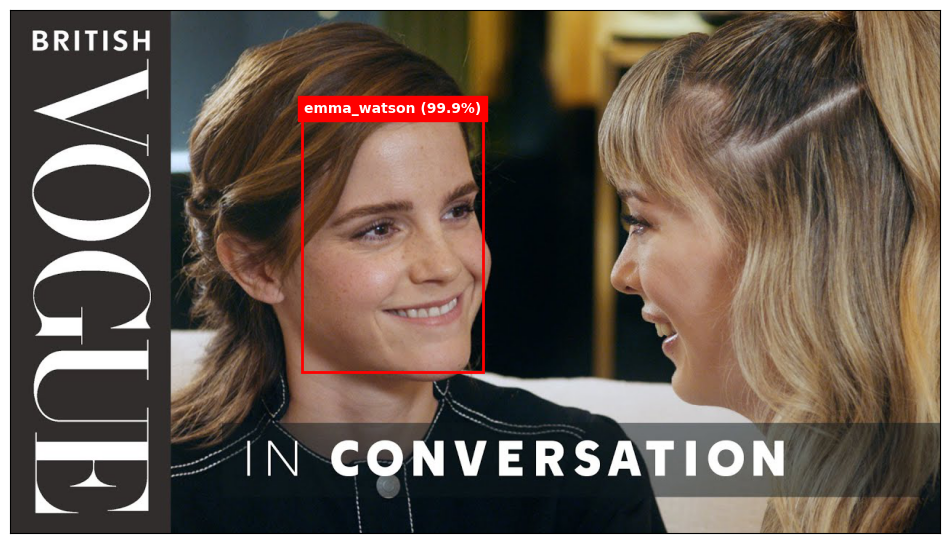

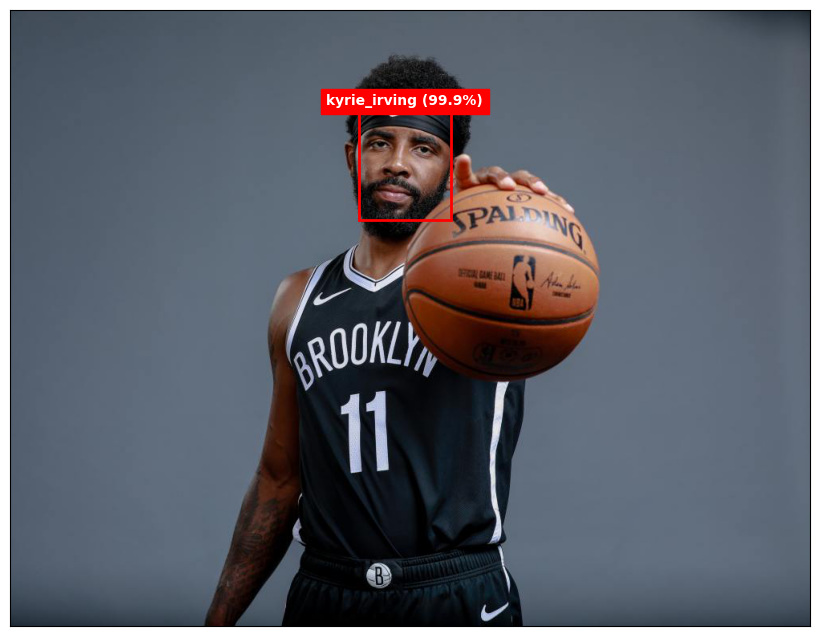

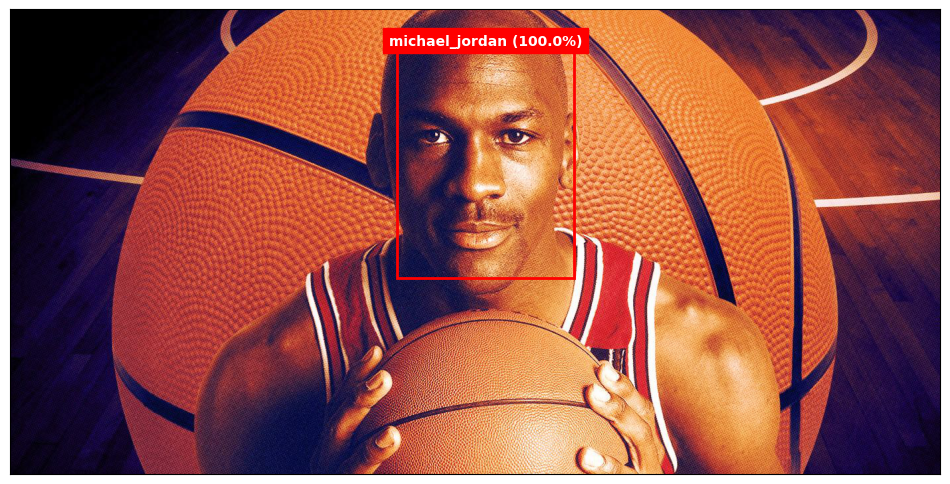

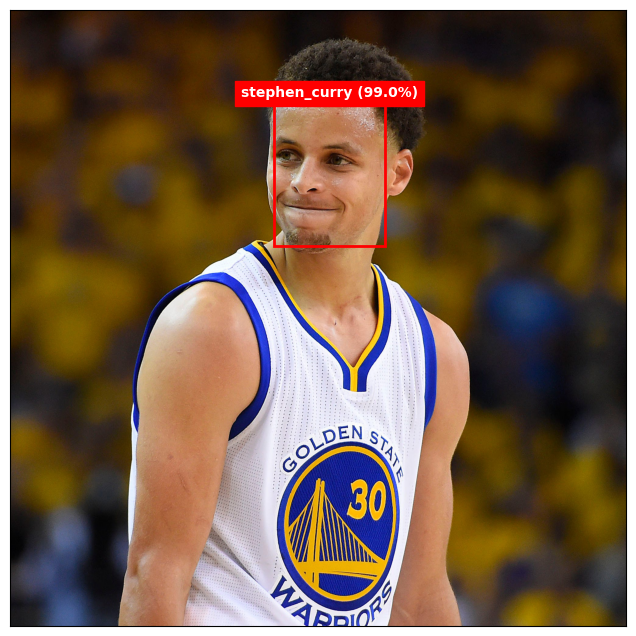

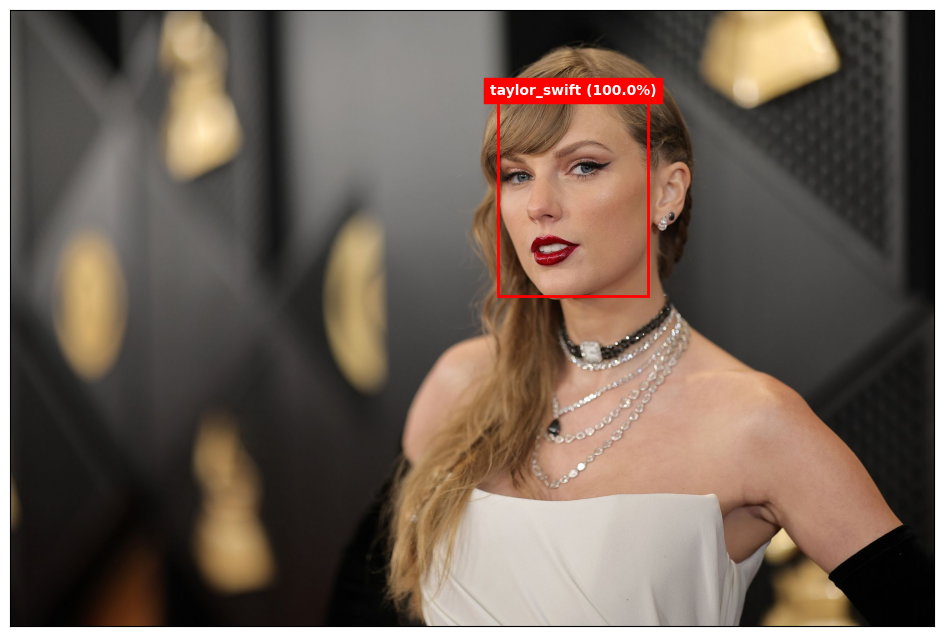

In [72]:
# Pass labels to function on first image to see how model does
labels = ['ariana_grande',
 'emma_watson',
 'kyrie_irving',
 'michael_jordan',
 'stephen_curry',
 'taylor_swift']
label_faces("C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\ariana_grande\\image_38.jpg",model,labels)
label_faces("C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\emma_watson\\image_38.jpg",model,labels)
label_faces("C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\kyrie_irving\\image_37.jpg",model,labels)
label_faces("C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\michael_jordan\\image_38.jpg",model,labels)
label_faces("C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\stephen_curry\\image_38.jpg",model,labels)
label_faces("C:\\Users\\USER\\Downloads\\chinxuanhan\\celebrity\\taylor_swift\\image_37.jpg",model,labels)

### Further evaluate model

In [122]:
# Functions below are used to further evaluate the model
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score
from PIL import Image, ImageOps
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications.resnet50 import preprocess_input


def make_pred(path, model, names, face_threshold=0.9, prediction_threshold=0.9, show_outline=True, size=(12, 8)):
    # Load the image and orient it correctly
    pil_image = Image.open(path)
    exif = pil_image.getexif()
    
    for k in exif.keys():
        if k != 0x0112:
            exif[k] = None
            del exif[k]
            
    pil_image.info["exif"] = exif.tobytes()
    pil_image = ImageOps.exif_transpose(pil_image)
    np_image = np.array(pil_image)

    detector = MTCNN()
    faces = detector.detect_faces(np_image)
    faces = [face for face in faces if face['confidence'] > face_threshold]

    for face in faces:
        x, y, w, h = face['box']

        # Use the model to identify the face
        face_image = get_face(np_image, face)
        face_image = image.array_to_img(face_image)
        face_image = preprocess_input(np.array(face_image))
        predictions = model.predict(np.expand_dims(face_image, axis=0))
        confidence = np.max(predictions)

        if (confidence > prediction_threshold):
            return predictions
            
        return None
        
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def get_all_images_from_directory(directory):
    images = []
    labels = []
    images_names = []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            images_names += [img for img in os.listdir(label_path)]
            images += [os.path.join(label_path, img) for img in os.listdir(label_path)]
            labels += [(label)] * len(os.listdir(label_path))
            
    # Embaralhar as imagens e labels
    combined = list(zip(images_names, images, labels))
    random.shuffle(combined)
    images_names, images, labels = zip(*combined)
    
    # Return images_names, images, labels
    return zip(*combined)

def predict_and_validate(model, image_names, image_paths, true_labels, class_labels):
    predictions = []
    for img_path in image_paths:
        predictions.append(make_pred(img_path, model, class_labels, prediction_threshold=0.8))
    
    results = [true == pred for true, pred in zip(true_labels, predictions)]
    
    df = pd.DataFrame({
        'People': image_names,
        'Prediction Array': predictions
    })
    
    return df

In [123]:
# Create prediction array
from IPython.display import clear_output

model_to_evaluate = model  

class_labels = {0: 'angelina_jolie', 1: 'bradley_cooper', 2: 'kate_siegel', 3: 'paul_rudd', 4: 'shea_whigham'} 
image_names, image_paths, true_labels = get_all_images_from_directory('C:\\Users\\USER\\Downloads\\chinxuanhan\\test_images')
prediction_df = predict_and_validate(model_to_evaluate, image_names, image_paths, true_labels, class_labels)
clear_output()
prediction_df

People                                   Prediction Array
0   angelina (5).jpg  [[0.0116889, 0.9883111, 3.4118354e-11, 2.40326...
1       kate (1).jpg  [[0.039357677, 0.9603358, 5.8584792e-05, 4.228...
2       kate (3).jpg  [[0.9999975, 2.5480583e-06, 6.688605e-11, 1.01...
3   angelina (4).jpg  [[0.990035, 0.00996499, 1.3345554e-14, 3.61363...
4   angelina (1).jpg  [[0.014688877, 0.9853092, 1.590622e-09, 1.6905...
5       kate (2).jpg  [[0.017138457, 0.9828615, 1.1205948e-09, 1.610...
6       shea (4).jpg  [[7.600846e-05, 0.99754435, 0.0008395635, 0.00...
7       paul (1).jpg  [[1.6517657e-06, 0.9999559, 2.3126506e-05, 3.4...
8       paul (3).jpg  [[8.251911e-06, 0.99986076, 5.8671696e-05, 8.3...
9       kate (5).jpg  [[0.004846746, 0.9951357, 5.4338933e-09, 1.012...
10  angelina (2).jpg  [[0.058939427, 0.9410604, 2.1638451e-10, 1.128...
11  angelina (3).jpg                                               None
12      kate (4).jpg                                               None
13      shea (3).jpg  [[0.00063559134, 0.93510073, 0.01274911, 0.018...
14      paul (5).jpg  [[1.03608464e-07, 0.9999949, 3.1149846e-06, 4....
15   bradley (3).jpg  [[1.3482921e-07, 0.99999595, 1.9995805e-06, 1....
16      shea (2).jpg                                               None
17      shea (5).jpg                                               None
18      paul (4).jpg  [[0.9394509, 0.033426866, 0.007271553, 0.00767...
19      paul (2).jpg  [[8.030271e-09, 0.9999957, 4.4460716e-08, 3.35...
20   bradley (5).jpg  [[3.2162646e-08, 0.9999851, 8.808133e-06, 1.24...
21   bradley (1).jpg  [[0.9734268, 0.009892399, 0.0056573283, 0.0046...
22   bradley (2).jpg  [[0.00041355143, 0.99535686, 0.0017269552, 0.0...
23      shea (1).jpg  [[0.0031373634, 0.95749414, 0.013978423, 0.009...
24   bradley (4).jpg                                               None

In [83]:
import pandas as pd

# Export classification model 
prediction_df.to_pickle('prediction_df')